# Model Regression for Loss Given Default 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

%config IPCompleter.greedy=True

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

In [2]:

df = pd.read_pickle('../../02_Data/03_Work/df_board_lgd.pickle')


In [3]:
x = df.drop(columns='target_lgd')
y = df.target_lgd

## MODEL

In [4]:

train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)


In [5]:
pipe = Pipeline([('algorithm',Ridge())])

grid = [      
        {'algorithm': [Ridge()],
         'algorithm__alpha': list(np.arange(0.1,1.1,0.1))},
        
        {'algorithm': [Lasso()],
         'algorithm__alpha': list(np.arange(0.1,1.1,0.1))},
    
        {'algorithm': [HistGradientBoostingRegressor(min_samples_leaf = 100, scoring = 'neg_mean_absolute_percentage_error')],
         'algorithm__learning_rate': [0.01,0.025,0.05,0.1],
         'algorithm__max_iter': [50,100,200],
         'algorithm__max_depth': [5,10,20],
         'algorithm__l2_regularization': [0,0.25,0.5,0.75,1]}
       ]

#### Optimize hyperparameters

In [6]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 3, 
                           scoring = 'neg_mean_absolute_error',
                           verbose = 0,
                           n_jobs = -1)

model = grid_search.fit(train_x,train_y)

In [7]:
# since it's very polarized, the model makes a lot of error
# the model makes a regression towards the mean
# this makes the model be "good" overall, but fails a lot when looking at specific cases



In [8]:
output = pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').reset_index(drop=True).head(10)
output

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_algorithm__alpha,param_algorithm__l2_regularization,param_algorithm__learning_rate,param_algorithm__max_depth,param_algorithm__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,20.94,0.43,0.55,0.05,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.75,0.10,20,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.37,-0.37,-0.37,-0.37,0.00,1
1,22.42,0.38,0.58,0.04,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.50,0.10,20,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.37,-0.37,-0.37,-0.37,0.00,2
2,20.47,0.18,0.54,0.02,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0,0.10,10,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.37,-0.38,-0.37,-0.37,0.00,3
3,21.11,0.36,0.63,0.12,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0,0.10,20,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.38,-0.37,-0.37,-0.37,0.00,4
4,14.92,0.27,0.24,0.00,HistGradientBoostingRegressor(min_samples_leaf...,NaN,1,0.10,20,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.38,-0.37,-0.37,-0.37,0.00,5
5,20.27,0.13,0.53,0.02,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.25,0.10,10,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.38,-0.38,-0.37,-0.37,0.00,6
6,20.42,0.03,0.52,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.75,0.10,10,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.38,-0.38,-0.37,-0.37,0.00,7
7,21.70,0.63,0.63,0.13,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.50,0.10,10,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.38,-0.37,-0.38,-0.38,0.00,8
8,18.27,0.58,0.27,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,1,0.10,10,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.38,-0.38,-0.37,-0.38,0.00,9
9,22.56,0.38,0.54,0.02,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.25,0.10,20,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.38,-0.38,-0.38,-0.38,0.00,10


In [9]:
model_lgd = HistGradientBoostingRegressor(learning_rate = 0.1,
                                          max_iter = 200,
                                          max_depth = 20,
                                          min_samples_leaf = 100,
                                          scoring = 'neg_mean_absolute_percentage_error',
                                          l2_regularization = 0.25)
model_lgd.fit(train_x,train_y)

HistGradientBoostingRegressor(l2_regularization=0.25, max_depth=20,
                              max_iter=200, min_samples_leaf=100,
                              scoring='neg_mean_absolute_percentage_error')

### Evaluate

In [10]:
pred = model_lgd.predict(val_x)

pred = np.where(pred < 0, 0, pred)
pred = np.where(pred > 1, 1, pred)

In [11]:
mean_absolute_error(val_y, pred)

0.37440690627993894

### Report

In [12]:
check_validation = pd.DataFrame({'lgd_real':val_y, 'lgd_pred':pred})
check_validation

,lgd_real,lgd_pred
client_id,,
93593115,0.00,0.52
123611250,1.00,0.71
7604612,0.00,0.17
65791987,0.00,0.45
78408775,1.00,0.74
...,...,...
144361858,1.00,0.98
142361142,1.00,0.88
84120392,0.00,0.41


In [13]:
check_validation.corr()

,lgd_real,lgd_pred
lgd_real,1.00,0.52
lgd_pred,0.52,1.00


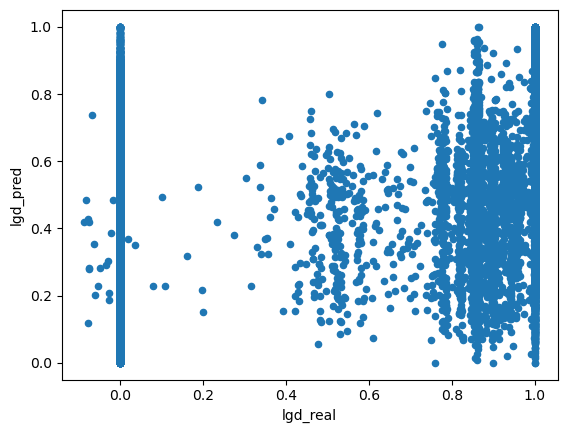

In [14]:
check_validation.plot.scatter(x='lgd_real',y='lgd_pred');

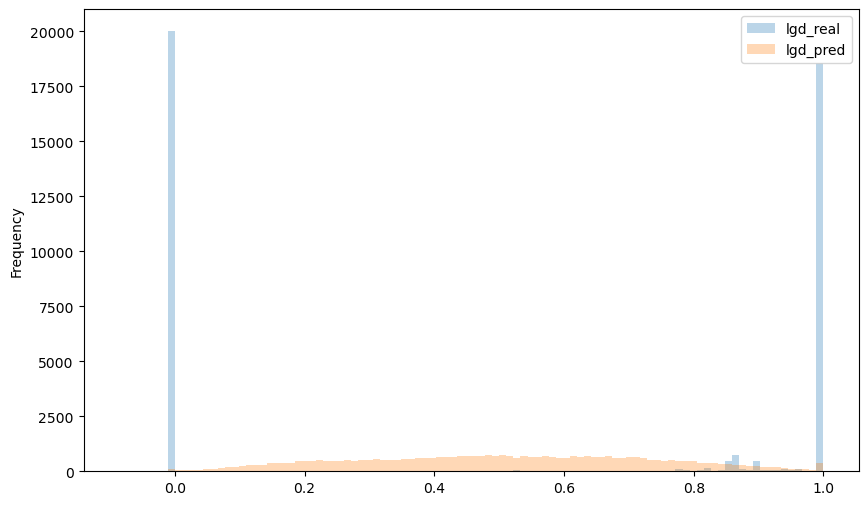

In [15]:
check_validation.plot.hist(bins = 100,figsize = (10,6), alpha = 0.3);